# Изучение закономерностей, определяющих успешность игр

## 1. Обзор данных

Составление первого представления о данных статистики архива компьютерных игр из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.

In [69]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats as st

In [70]:
data = pd.read_csv('games.csv' ,sep=',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [71]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


с помощью метода info() проверили какие типы данные в каждом столбце и выяснили, что необходимо изменить тип данных в двух столбцах: Year_of_Release, User_Score. Недочеты:
1. Name - пустые значения
2. Year_of_Release - пустые значения,  изменить с float на int32
3. Genre - пустые значения
4. Critic_Score- пустые значения
5. User_Score - пустые значения и tbd. Тип данных в столбце необходимо изменить с object на float
6. Rating - пустые значения


###  2. Предобработка данных

#### Изменение названий столбцов

In [72]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

#### Обработка пропущеных значений

В шести столбцах из одинадцати есть пропущенные значения, необходимо найти их долю, для того чтобы понять, что делать с ними далее:

In [73]:
# подсчёт пропусков
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [74]:
# функция для подсчета доли пропусков
def pass_value(value, name):
    miss_part = value / 16715
    return print(f'{name} {miss_part:.1%}')

In [75]:
# подсчет доли пропусков
for col in data.columns:
    pass_value(data[col].isna().sum(), col)

name 0.0%
platform 0.0%
year_of_release 1.6%
genre 0.0%
na_sales 0.0%
eu_sales 0.0%
jp_sales 0.0%
other_sales 0.0%
critic_score 51.3%
user_score 40.1%
rating 40.5%


Причиной появления настоящих пропусков могла стать ошибка при переносе данных или данные просто могли быть не указаны изначально.

In [76]:
# удаление пропущеных значений
data.dropna(subset =['name','genre','year_of_release'])

# подсчёт пропусков
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

В столбце 'name' отсутствует 2 значения. Будет не понятно о какой игре идет речь, удаляем две строки. Появление припуска может быть связано с тем, что или его забыли указать при заведении данных, или у игры не было утверждено официальное название и поэтому ячейка оказалась пуста.


Так же удаляем строки с пустыми значениями из столбца "genre" . Пропуск может быть связан с тем, что при заполнении данных об игре забыли указать или не определились к какому именно жанру относится видеоигра.

Предлагаю удалить пропуски в  year_of_release, чтобы не было нелогичного установления года выпуска. Пропуск в данном столбце мог возникнуть из-за того, что при заполнении данных забыли поставить дату  или точная дата выхода игры не определена.


In [77]:
# просмотр уникальных значений в столбце platform
display(data['platform'].value_counts())

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       29
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64

In [78]:
# оценка критиков (максимум 100)
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

Корректной замены для пропусков в critic_score - нет, любое заполнение исказит результаты дальнейших расчетов.

In [79]:
# рейтинг от организации ESRB
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [80]:
data['rating'] = data['rating'].replace('K-A', 'E10+')

https://en.wikipedia.org/wiki/Entertainment_Software_Rating_Board#Ratings
В столбце 'rating' есть два значения 'K-A' и 'E10+' - это два значения носящие один и тот же смысл (первоначально "K-A" ("Kids to Adults"),переименовано в конце 20 в. на E10+ ). В столбце очень много пропущенных значений, скорее всего это связано с тем что рейтинг 'ESRB' был установлен в 1994. Данные удалятся не будут.

In [81]:
data['rating'].fillna('No rating', inplace=True)

In [82]:
data['rating'].isnull().sum()

0

In [83]:
# просмотр уникальных значений в столбце user_score
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

TBD - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято. То есть, данные были нарочно не заполнены, так как не определились с рейтингом. Заменим 'tbd' на 'Nan'. Переведем тип данных из объекта в числовой (float64), для дальнейших расчетов

In [84]:
data['user_score'] = data['user_score'].replace('tbd', 'nan') 
data['user_score'] = data['user_score'].astype('float64')
data['user_score'] = data['user_score'].fillna(0)
for i in data[data['user_score'].isnull() == True].index:  
    data['user_score'][i] = data.loc[data['name'] == data['name'][i], 'user_score'].max()

#### Изменение типов данных

#### Подсчет суммарных продаж во всех регионах и внесение их в отдельный столбец

In [93]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [94]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,0.0,No rating,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,0.0,No rating,31.38


В столбце 'name' небыло 2 значения. Строки удалены. Появление припуска может быть связано с тем, что или его забыли указать при заведении данных, или у игры не было утверждено официальное название и поэтому ячейка оказалась пуста.Так же удалили строки с пустыми значениями из столбца "genre" . Пропуск может быть связан с тем, что при заполнении данных об игре забыли указать или не определились к какому именно жанру относится видеоигра.

В столбце 'rating' есть два значения 'K-A' и 'E10+' - это два значения носящие один и тот же смысл (первоначально "K-A" ("Kids to Adults"),переименовано в конце 20 в. на E10+ ). В столбце очень много пропущенных значений, скорее всего это связано с тем что рейтинг 'ESRB' был установлен в 1994

TBD - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято. То есть, данные были нарочно не заполнены, так как не определились с рейтингом.Перевеводим тип данных в числовой (float64)

### 3. Исследовательский анализ данных

#### Количество игр выпущенных в разные годы

In [95]:
#Посмотрите, сколько игр выпускалось в разные годы.
data_games = data.groupby('year_of_release')['name'].count()
data_games 

year_of_release
1980.0       9
1981.0      46
1982.0      36
1983.0      17
1984.0      14
1985.0      14
1986.0      21
1987.0      16
1988.0      15
1989.0      17
1990.0      16
1991.0      41
1992.0      43
1993.0      60
1994.0     121
1995.0     219
1996.0     263
1997.0     289
1998.0     379
1999.0     338
2000.0     350
2001.0     482
2002.0     829
2003.0     775
2004.0     762
2005.0     939
2006.0    1006
2007.0    1197
2008.0    1427
2009.0    1426
2010.0    1255
2011.0    1136
2012.0     653
2013.0     544
2014.0     581
2015.0     606
2016.0     502
Name: name, dtype: int64

Наибольшее количествово игр было выпущено в 2008-2009 г. Данные за период более 35 лет- слишком большой интервал. Большая часть платформ уже не существует это не даст нам правильных данных для анализа.

#### Изменения продаж по платформам

In [96]:
pop_platform=data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head()
pop_platform

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
Name: total_sales, dtype: float64

Платформы с наибольшими суммарными продажами за весь период являются PS2, X360, PS3,Wii

In [99]:
#Возьмем платформы с наибольшими суммарными продажами и постройте распределение по годам.
data_pop = data.query("platform == ['X360', 'PS3', 'PS2','Wii']")

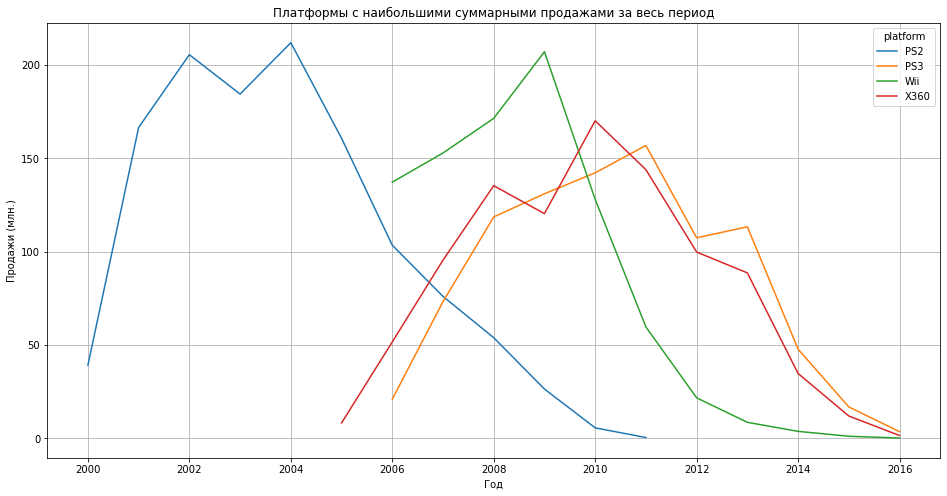

In [100]:
data_pop.query("platform == ['X360', 'PS3', 'PS2','Wii']")
data1=data_pop.pivot_table(index='year_of_release', columns = 'platform', values='total_sales', aggfunc='sum')
data1.plot(grid=True, figsize=(16, 8))
plt.title('Платформы с наибольшими суммарными продажами за весь период')
plt.xlabel('Год')
plt.ylabel('Продажи (млн.)')
plt.show()

Исходя из данных в графике в среднем продолжительность жизни каждой платформы составляет 10 лет 

#### Выделение актуального периода

Актуальные период для прогноза на 2017 возьмем с 2015 по 2016 года. Данный период выбран в связи с тем, чтобы мы могли посмотреть какие платформы в принципе не будут продаваться. Не стоит брать данные за меньший период (только за 2016), потомучто 2016 в данных представлен не полностью 

In [101]:
period_data = data[data['year_of_release'] >=2015]
period_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,0.0,No rating,14.63
77,FIFA 16,PS4,2015.0,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015.0,Shooter,2.99,3.49,0.22,1.28,NaN,0.0,No rating,7.98
94,FIFA 17,PS4,2016.0,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
99,Call of Duty: Black Ops 3,XOne,2015.0,Shooter,4.59,2.11,0.01,0.68,NaN,0.0,No rating,7.39
...,...,...,...,...,...,...,...,...,...,...,...,...
16699,The Longest 5 Minutes,PSV,2016.0,Action,0.00,0.00,0.01,0.00,NaN,0.0,No rating,0.01
16703,Strawberry Nauts,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,0.0,No rating,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,0.0,No rating,0.01
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,0.0,No rating,0.01


#### Выделение потенциально прибыльных платформ


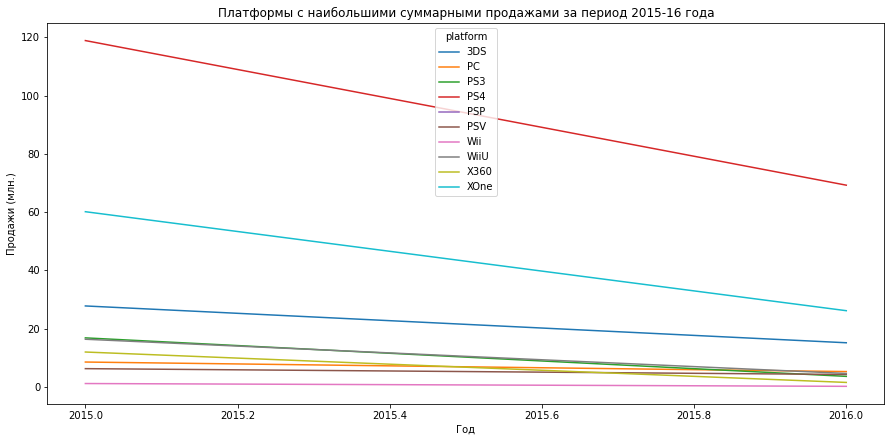

In [102]:
period_data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').plot(figsize=(15,7))
plt.title('Платформы с наибольшими суммарными продажами за период 2015-16 года')
plt.xlabel('Год')
plt.ylabel('Продажи (млн.)')
plt.show()

Отталкиваясь от нашего графика, можно сделать  вывод - потенциально прибыльной платформой можно считать PS4 и XOne. Именно эти платформы актуальны . Xbox One так же имеет продажи, но значительно меньше. 

Лидирует по продажам PS4 и XOne, но продажи падают к 2016 году. Эти платформы и будут актуальными 

#### Глобальные продажи игр в разбивке по платформам

Построение графиков «ящик с усами» по глобальным продажам игр в разбивке по платформам. Описание результатов.

In [107]:
data_2017 =  data[data['platform'].isin(['PS4','XOne','PS3','3DS','WiiU'])]
data_2017

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,0.0,No rating,14.63
33,Pokemon X/Pokemon Y,3DS,2013.0,Role-Playing,5.28,4.19,4.35,0.78,NaN,0.0,No rating,14.60
34,Call of Duty: Black Ops II,PS3,2012.0,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
37,Call of Duty: Modern Warfare 3,PS3,2011.0,Shooter,5.54,5.73,0.49,1.57,88.0,3.2,M,13.33
...,...,...,...,...,...,...,...,...,...,...,...,...
16676,G1 Jockey 4 2008,PS3,2008.0,Sports,0.00,0.00,0.00,0.00,NaN,0.0,No rating,0.00
16677,Aikatsu Stars! My Special Appeal,3DS,2016.0,Action,0.00,0.00,0.01,0.00,NaN,0.0,No rating,0.01
16688,Outdoors Unleashed: Africa 3D,3DS,2011.0,Sports,0.01,0.00,0.00,0.00,NaN,0.0,T,0.01
16691,Dynasty Warriors: Eiketsuden,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,0.0,No rating,0.01


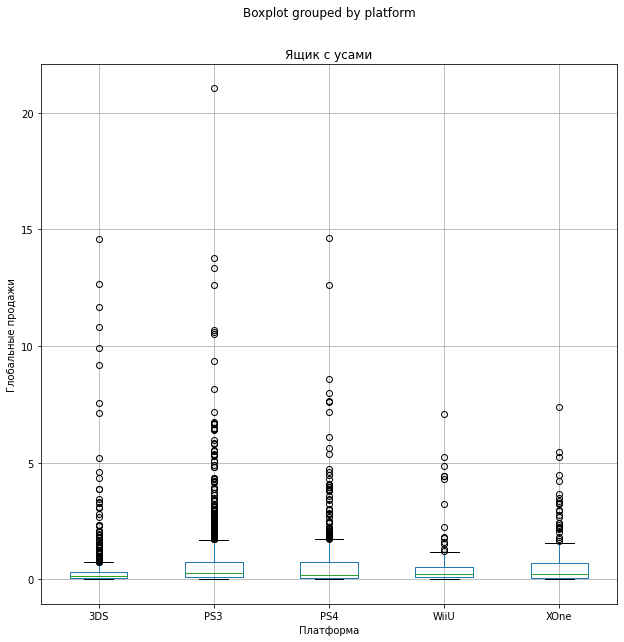

In [108]:
data_2017.boxplot(column='total_sales', by='platform', figsize=(10,10))
plt.title('Ящик с усами')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи')
plt.show()


Рассматривая общую диаграмму размаха стоит отметить частые и редкие выбросы. Данные выбросы стоит оставить, ведь есть игры с очень высокими продажами в мире, со своей базой фанатов, например. Такие выбросы нельзя исключать 

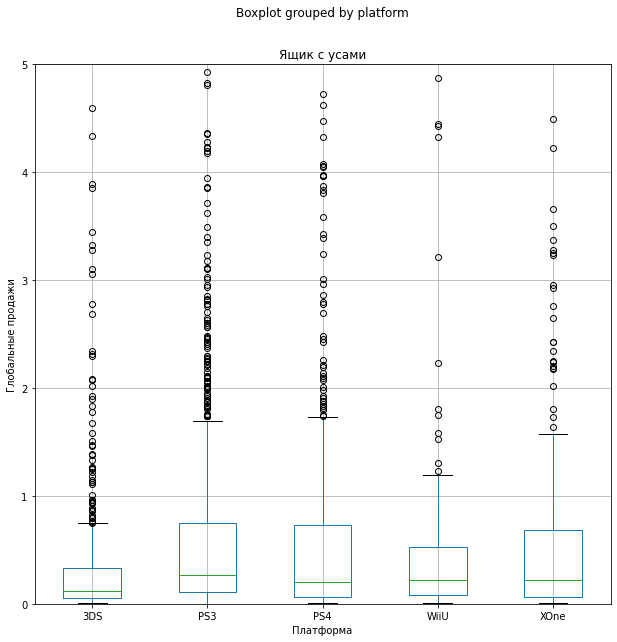

In [109]:
#построим график второй, который будет ограничивать по оси Y, чтобы рассмотреть квартили и усы распределений.
data_2017.boxplot(column='total_sales', by='platform', figsize=(10,10))
plt.ylim(0, 5)
plt.title('Ящик с усами')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи')
plt.show()

#### Влияние на продажи отзывов пользователей и критиков внутри одной популярной платформы

Для диагностики возьмем платформу PS4, т.к. у этой платформы значительные продажи в 2016 году.

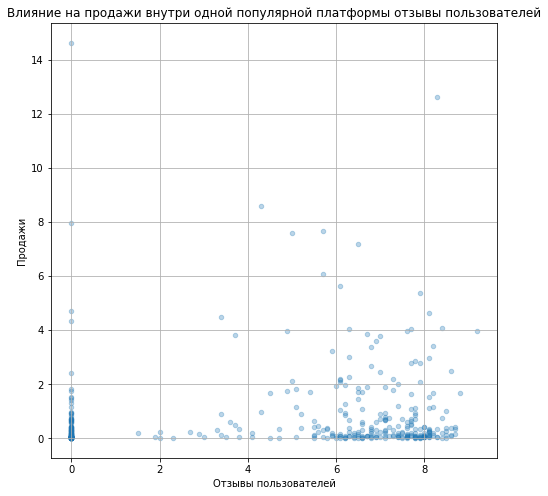

In [110]:
# Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей
data[data['platform']=='PS4'].plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(8,8), grid=True)
plt.title('Влияние на продажи внутри одной популярной платформы отзывы пользователей')
plt.xlabel('Отзывы пользователей')
plt.ylabel('Продажи')
plt.show()

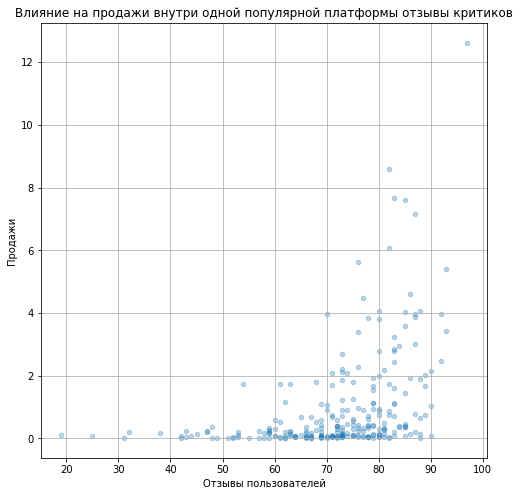

In [111]:
# Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы критиков
data[data['platform']=='PS4'].plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(8,8), grid=True)
plt.title('Влияние на продажи внутри одной популярной платформы отзывы критиков')
plt.xlabel('Отзывы пользователей')
plt.ylabel('Продажи')
plt.show()

In [112]:
# посчитаем корреляцию между отзывами пользователей и продажами
data_ps4 = data[data['platform']=='PS4']

data_ps4_user = data_ps4[data_ps4['user_score'] != 0]
data_ps4_cor_user = data_ps4_user['user_score'].corr(data_ps4_user['total_sales'])
print("Уровень кореляции между отзывами пользователей и продажами:" ,data_ps4_cor_user)

data_ps4_critic = data_ps4[data_ps4['critic_score'] != 0]
data_ps4_cor_critic = data_ps4_critic['critic_score'].corr(data_ps4_critic['total_sales'])
print("Уровень кореляции между отзывами критиков и продажами:" ,data_ps4_cor_critic)

Уровень кореляции между отзывами пользователей и продажами: -0.03195711020455646
Уровень кореляции между отзывами критиков и продажами: 0.4065679020617814


В оценке пользователей на продажи  линейной связи между признаками нет, чего не скажешь об оценке критиков. Покупатели прислушиваются больше к критикам чем к оценкам других пользователей


#### Соотношение выводов с продажами игр на других платформах.

In [113]:
data_2017.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS3     939.65
PS4     314.14
3DS     259.00
XOne    159.32
WiiU     82.19
Name: total_sales, dtype: float64

Рассмотрим игры от PS3 до WiiU . Заметна большая разница в продажах между PS4 - 314.14 и PS3 - 931.34

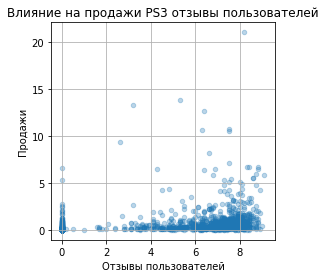

In [114]:
# Рассмотрим, как влияют на продажи PS3 отзывы пользователей
data_2017[data_2017['platform']=='PS3'].plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(4,4), grid=True)
plt.title('Влияние на продажи PS3 отзывы пользователей')
plt.xlabel('Отзывы пользователей')
plt.ylabel('Продажи')
plt.show()

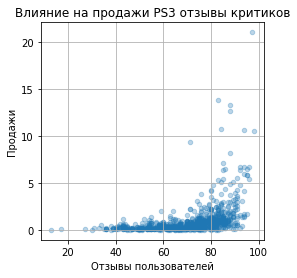

In [115]:
# Рассмотрим, как влияют на продажи  PS3 отзывы критиков
data_2017[data_2017['platform']=='PS3'].plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(4,4), grid=True)
plt.title('Влияние на продажи PS3 отзывы критиков')
plt.xlabel('Отзывы пользователей')
plt.ylabel('Продажи')
plt.show()

In [119]:
# Посчитаем корреляцию между отзывами пользователей и продажами PS3
data_ps3 = data_2017[data_2017['platform']=='PS3']
data_ps3_user = data_ps3[data_ps3['user_score'] != 0]
data_ps3_cor_user = data_ps3_user['user_score'].corr(data_ps3_user['total_sales'])
print("Уровень кореляции между отзывами пользователей и продажами PS3:" ,data_ps3_cor_user)
# Посчитаем корреляцию между отзывами критиков и продажами PS3
data_ps3_critic = data_ps3[data_ps3['critic_score'] != 0]
data_ps3_cor_critic = data_ps3_critic['critic_score'].corr(data_ps3_critic['total_sales'])
print("Уровень кореляции между отзывами критиков и продажами PS3:" ,data_ps3_cor_critic)

Уровень кореляции между отзывами пользователей и продажами PS3: 0.12669133936341703
Уровень кореляции между отзывами критиков и продажами PS3: 0.43243156856420595


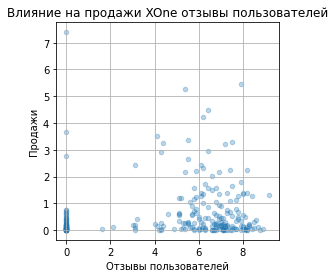

In [120]:
# Посчитаем, как влияют на продажи XOne отзывы пользователей
data_2017[data_2017['platform']=='XOne'].plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(4,4), grid=True)
plt.title('Влияние на продажи XOne отзывы пользователей')
plt.xlabel('Отзывы пользователей')
plt.ylabel('Продажи')
plt.show()

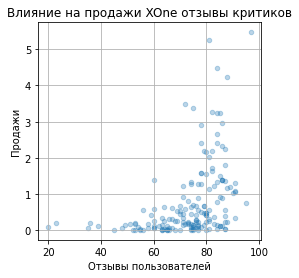

In [121]:
# Посчитаем,, как влияют на продажи XOne отзывы критиков
data_2017[data_2017['platform']=='XOne'].plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(4,4), grid=True)
plt.title('Влияние на продажи XOne отзывы критиков')
plt.xlabel('Отзывы пользователей')
plt.ylabel('Продажи')
plt.show()

In [122]:
# Посчитаем, корреляцию между отзывами пользователей и продажами XOne
data_xone = data_2017[data_2017['platform']=='XOne']
data_xone_user = data_xone[data_xone['user_score'] != 0]
data_xone_cor_user = data_xone_user['user_score'].corr(data_xone_user['total_sales'])
print("Уровень кореляции между отзывами пользователей и продажами XOne:" ,data_xone_cor_user)
# Посчитаем, корреляцию между отзывами критиков и продажами XOne
data_xone_critic = data_xone[data_xone['critic_score'] != 0]
data_xone_cor_critic = data_xone_critic['critic_score'].corr(data_xone_critic['total_sales'])
print("Уровень кореляции между отзывами критиков и продажами XOne:" ,data_xone_cor_critic)

Уровень кореляции между отзывами пользователей и продажами XOne: -0.06892505328279418
Уровень кореляции между отзывами критиков и продажами XOne: 0.4169983280084015


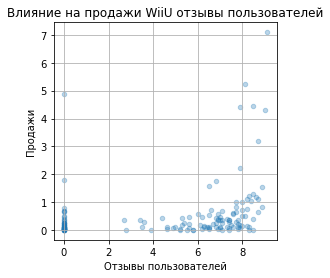

In [123]:
# Посчитаем, как влияют на продажи WiiU отзывы пользователей
data_2017[data_2017['platform']=='WiiU'].plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(4,4), grid=True)
plt.title('Влияние на продажи WiiU отзывы пользователей')
plt.xlabel('Отзывы пользователей')
plt.ylabel('Продажи')
plt.show()

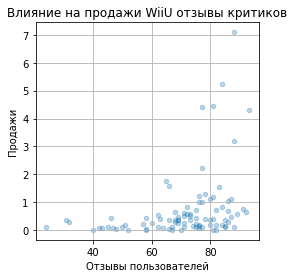

In [124]:
# Посчитаем, как влияют на продажи WiiU отзывы критиков
data_2017[data_2017['platform']=='WiiU'].plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(4,4), grid=True)
plt.title('Влияние на продажи WiiU отзывы критиков')
plt.xlabel('Отзывы пользователей')
plt.ylabel('Продажи')
plt.show()

In [125]:
# Посчитаем,корреляцию между отзывами пользователей и продажами WiiU
data_wiiu = data_2017[data_2017['platform']=='WiiU']
data_wiiu_user = data_wiiu[data_wiiu['user_score'] != 0]
data_wiiu_cor_user = data_wiiu_user['user_score'].corr(data_wiiu_user['total_sales'])
print("Уровень кореляции между отзывами пользователей и продажами WiiU:" ,data_wiiu_cor_user)
# посчитайте корреляцию между отзывами критиков и продажами Wii
data_wiiu_critic = data_wiiu[data_wiiu['critic_score'] != 0]
data_wiiu_cor_critic = data_wiiu_critic['critic_score'].corr(data_wiiu_critic['total_sales'])
print("Уровень кореляции между отзывами критиков и продажами WiiU:" ,data_wiiu_cor_critic)

Уровень кореляции между отзывами пользователей и продажами WiiU: 0.4002190202148617
Уровень кореляции между отзывами критиков и продажами WiiU: 0.3483797601201749


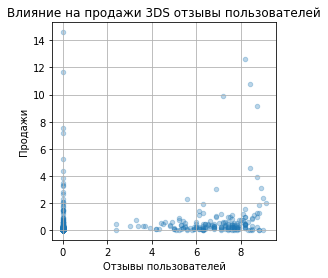

In [126]:
# Посчитаем, как влияют на продажи 3DS отзывы пользователей
data_2017[data_2017['platform']=='3DS'].plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(4,4), grid=True)
plt.title('Влияние на продажи 3DS отзывы пользователей')
plt.xlabel('Отзывы пользователей')
plt.ylabel('Продажи')
plt.show()

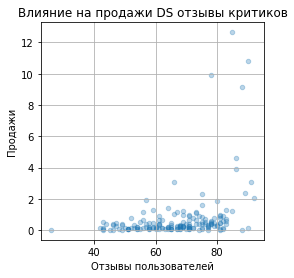

In [127]:
# Посчитаем, как влияют на продажи 3DS отзывы критиков
data_2017[data_2017['platform']=='3DS'].plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(4,4), grid=True)
plt.title('Влияние на продажи DS отзывы критиков')
plt.xlabel('Отзывы пользователей')
plt.ylabel('Продажи')
plt.show()

In [128]:
# Посчитаем, корреляцию между отзывами пользователей и продажами 3DS
data_3ds = data_2017[data_2017['platform']=='3DS']
data_3ds_user = data_3ds[data_3ds['user_score'] != 0]
data_3ds_cor_user = data_3ds_user['user_score'].corr(data_3ds_user['total_sales'])
print("Уровень кореляции между отзывами пользователей и продажами 3DS:" ,data_3ds_cor_user)
# Посчитаем, корреляцию между отзывами критиков и продажами 3DS
data_3ds_critic = data_3ds[data_3ds['critic_score'] != 0]
data_3ds_cor_critic = data_3ds_critic['critic_score'].corr(data_3ds_critic['total_sales'])
print("Уровень кореляции между отзывами критиков и продажами 3DS:" ,data_3ds_cor_critic)

Уровень кореляции между отзывами пользователей и продажами 3DS: 0.2248079803957107
Уровень кореляции между отзывами критиков и продажами 3DS: 0.3494009303924131


У PS3,XOne, 3DS, WiiU наблюдается пусть и не сильная, но всё же, связь между оценками критиков и продажами. А связь между оценками пользователей и продажами слабая у всех платформ. У XOne связь слабая отрицательная. Только у WiiU корреляция между отзывами пользователей выше чем между продажами к отзывам критиков. 
Поэтому общий вывод остаестя прежним, что покупатели прислушиваются больше к критикам, нежели к оценкам других пользователей. 

####  Общее распределение игр по жанрам. 

Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [129]:
pop_genre=data_2017.groupby('genre')['total_sales'].sum().sort_values(ascending=False)
pop_genre

genre
Action          512.31
Shooter         348.73
Sports          225.46
Role-Playing    200.37
Racing          116.89
Platform         92.48
Misc             85.93
Fighting         79.04
Simulation       39.95
Adventure        36.42
Strategy          9.22
Puzzle            7.50
Name: total_sales, dtype: float64

Среди самых прибыльных жанров лидируют Action, Sports, Shooter. Стоит отметить, что в этих жанрах делается упор на эксплуатацию физических возможностей игрока. Игры с низкими продажами являются Puzzle, которые направлены на развитие логического мышления, внимания, памяти. Игры с высокими и низкими продажами отличаются от друг друга в 70 раз по количеству продаж

Количество игр сильно различаться, посчитаем медианные продажи игр по жанрам, чтобы понять, какой жанр обычно продается лучше.

In [130]:
data_2017.groupby('genre').median().sort_values('total_sales' , ascending=False)

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
genre,,,,,,,,
Shooter,2012.0,0.230,0.21,0.01,0.08,74.5,6.4,0.595
Platform,2013.0,0.120,0.12,0.00,0.04,75.5,6.3,0.340
Fighting,2012.5,0.115,0.07,0.04,0.03,75.0,7.0,0.320
Sports,2012.0,0.130,0.05,0.00,0.03,76.0,5.3,0.265
Racing,2011.0,0.100,0.12,0.00,0.03,73.0,6.1,0.260
Role-Playing,2013.5,0.060,0.02,0.07,0.02,74.0,5.0,0.230
Action,2013.0,0.080,0.04,0.01,0.02,71.0,5.7,0.210
Simulation,2012.0,0.070,0.02,0.02,0.01,66.0,0.0,0.190
Misc,2012.0,0.070,0.03,0.00,0.01,73.0,0.0,0.160


Исходя из данных в графике в среднем продолжительность жизни каждой платформы составляет 10 лет
Актуальные период для прогноза на 2017 возьмем с 2015 по 2016 года. Данный период выбран в связи с тем, чтобы мы могли посмотреть какие платформы в принципе не будут продаваться. Не стоит брать данные за меньший период (только за 2016), потому что 2016 в данных представлен не полностью

Можно выделить лидирующую платформу - PS4.

Рассматривая общую диаграмму размаха стоит отметить частые и редкие выбросы. Данные выбросы стоит оставить, ведь есть игры с очень высокими продажами в мире, со своей базой фанатов, например. Такие выбросы нельзя исключать

У PS3,XOne, 3DS, WiiU наблюдается пусть и не сильная, но всё же, связь между оценками критиков и продажами. А связь между оценками пользователей и продажами слабая у всех платформ. У XOne связь слабая отрицательная. Только у WiiU корреляция между отзывами пользователей выше чем между продажами к отзывам критиков. 
Поэтому общий вывод остаестя прежним, что покупатели прислушиваются больше к критикам, нежели к оценкам других пользователей

Среди самых прибыльных жанров лидируют Action, Sports, Shooter. Стоит отметить, что в этих жанрах делается упор на эксплуатацию физических возможностей игрока. Игры с низкими продажами являются Puzzle, которые направлены на развитие логического мышления, внимания, памяти. Игры с высокими и низкими продажами отличаются от друг друга в 70 раз по количеству продаж

После подсета медианные продажи игр по жанрам, на лидирующую позицию выходит Shooter, Platform, Fighting.Игры с низкими продажами являются Adventure, Strategy, Puzzle  


###  4. Портрет пользователя каждого региона

**Самые популярные платформы (топ-5)**

Определить для пользователя каждого региона (NA, EU, JP): Самые популярные платформы (топ-5).

In [134]:
# функция жля построения графиков и таблиц
def top5(row):
    sales = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
    
    # число рядов и столбцов в сетке графиков
    col_count, row_count = 2, 2
    
    # размер графиков
    plt.figure(figsize = (15, 7))
    
    for i, sale in enumerate(sales):
        ptable = (data_2017
                  .pivot_table(index=row, values=sale, aggfunc='sum')
                  .sort_values(by=sale, ascending=False)
                  .reset_index()
                  .head(5))
        display(ptable)
        print('\n')
        
        sns.barplot(data=ptable, x=row, y=sale, ax = plt.subplot(row_count, col_count, i + 1))
        
        # добавление подзаголовков на каждый график
        plt.title(sale)
        
        # настройка подзаголовков
        plt.tight_layout()
    return

,platform,na_sales
0,PS3,393.49
1,PS4,108.74
2,XOne,93.12
3,3DS,83.49
4,WiiU,38.10


,platform,eu_sales
0,PS3,330.29
1,PS4,141.09
2,3DS,61.48
3,XOne,51.59
4,WiiU,25.13


,platform,jp_sales
0,3DS,100.67
1,PS3,80.19
2,PS4,15.96
3,WiiU,13.01
4,XOne,0.34


,platform,other_sales
0,PS3,135.68
1,PS4,48.35
2,XOne,14.27
3,3DS,13.36
4,WiiU,5.95


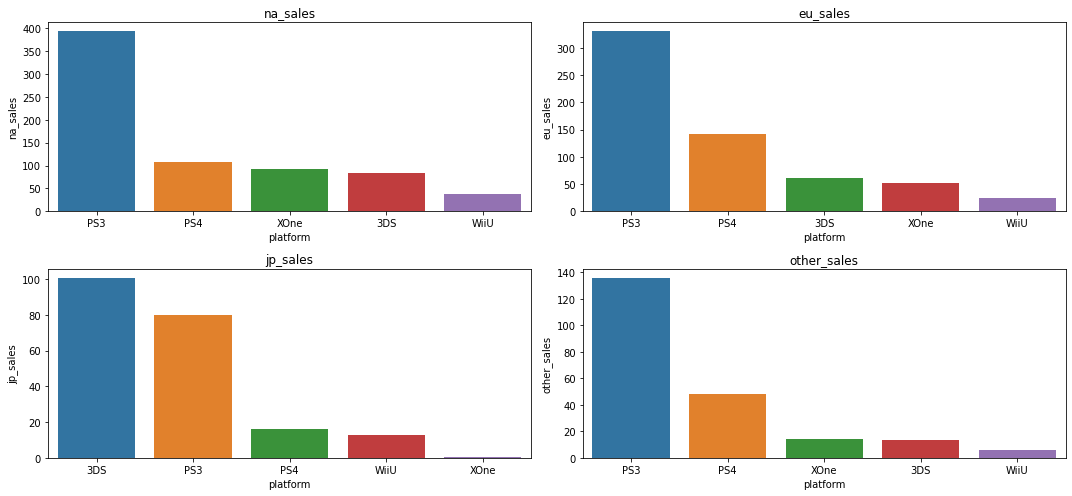

In [135]:
top5('platform')

В основном самой популярной платформой является PS3, для большинства регионов, кроме Японии, в Японии первое место по популярности занимает более старая платформа 3DS, в то время как для других стран она почти не актуальна 

**Самые популярные жанры (топ-5)**

,genre,na_sales
0,Action,205.16
1,Shooter,154.55
2,Sports,99.44
3,Role-Playing,70.24
4,Racing,40.68


,genre,eu_sales
0,Action,180.83
1,Shooter,131.70
2,Sports,84.44
3,Racing,52.12
4,Role-Playing,49.51


,genre,jp_sales
0,Role-Playing,63.29
1,Action,59.35
2,Shooter,13.52
3,Simulation,11.84
4,Fighting,11.55


,genre,other_sales
0,Action,66.97
1,Shooter,48.96
2,Sports,30.11
3,Role-Playing,17.33
4,Racing,16.52


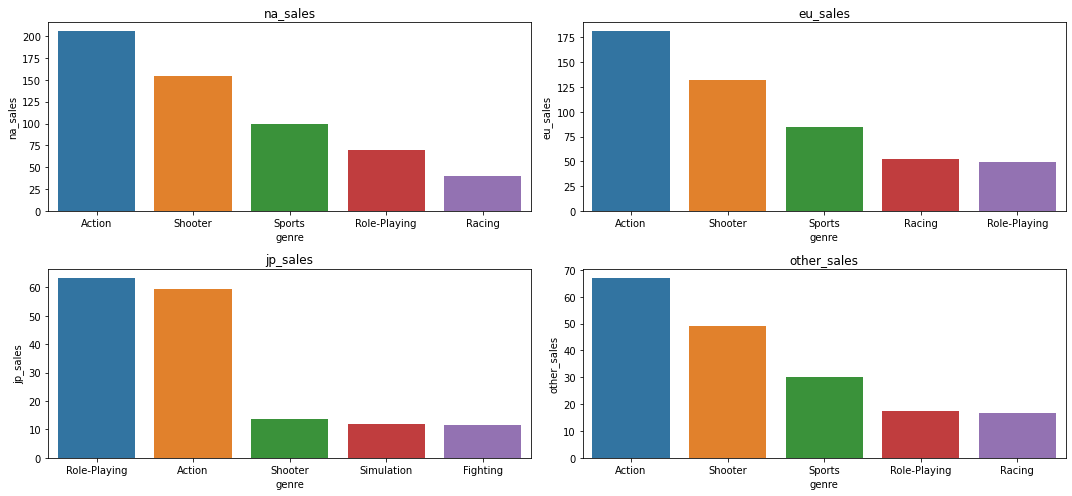

In [137]:
top5('genre')

Самым популярным жанорм является Action, для большинства регионов, но снова отличилась Япония, там первое место по популярности занимает жанр Role-Playing, a Action занимает второе место. На втором месте по популярности, в большинстве регионов, жанр Shooter, тогда как в Японии он занимает последнее место среди Топ-5 популярных жанров.

#### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [138]:
#рейтинг игр в NA
rating_na = data_2017.groupby('rating')['na_sales'].sum().sort_values(ascending=False)
rating_na

rating
M            251.81
E            152.41
T            134.75
No rating    101.50
E10+          76.47
Name: na_sales, dtype: float64

In [139]:
#рейтинг игр в EU
rating_eu = data_2017.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)
rating_eu

rating
M            220.26
E            137.31
No rating    100.55
T             97.84
E10+          53.62
Name: eu_sales, dtype: float64

In [140]:
#рейтинг игр в JP
rating_jp = data_2017.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)
rating_jp

rating
No rating    95.74
E            37.39
T            35.97
M            32.10
E10+          8.97
Name: jp_sales, dtype: float64

Топ рейтинга в NA:
* M («Mature») — «Для взрослых»
* E («Everyone») — «Для всех»
* T («Teen») — «Подросткам»

Топ рейтинга в EU:
* M («Mature») — «Для взрослых»
* E («Everyone») — «Для всех»
* No rating 

Топ рейтинга в JP:
* No rating 
* E («Everyone») — «Для всех»
* M («Mature») — «Для взрослых»

E» («Everyone») — «Для всех», «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет, «M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет. Рейтинг на продажи в отдельном регионе не влияет, т.к они практически одинаковы. На всёх 3 рынках доминируют игры с рейтингом М.

Выводы:

Японский рынок выглядит обособленым от остальных. Европейский и американский во многом схожи. Стоит отметить что  WiiU была нацелена именно на американский рынок, учитывая то, что в других странах она не получила популярность. 

- Самой популярной линейкой-платформ в NA является - XOne, в EU является - 4PC,  в JP является - Nintendo 3DS

Рейтинг по жанрам:
- в  NA является - Action
- в Европе - Action
- в Японии - Role-Playing

Популярным жанром будет Action, даже у Японских геймеров он занимает вторую сточку 

ESRB рейтинг оказывает небольшое влияние на продажи в Северной Америке, Европе и других странах, но в Японии - нет.

Рынок Японии может отличаться тем, что Nintendo не является стационарной игровой приставкой. Т.е выбирая XOne и  4PC покупатель тратит свое свободное время дома. У Японцев, видимо это не принято (из-за отсутствия свободного времени или наличия места свободного дома)и они берут приставку в дорогу 

### 5. Проверка гипотез

#### Гипотеза № 1: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

#### Для проверки гипотезы "средние пользовательские рейтинги платформ Xbox One и PC одинаковые" в качестве нулевой и альтернативной гипотезы мы взяли следующее:

H_0: Средние пользовательские рейтинги платформ Xbox One = Средние пользовательские рейтинги платформ PC 

H_a: Средние пользовательские рейтинги платформ Xbox One ≠ Средние пользовательские рейтинги платформ PC 

alpha = 0.05

Генеральные совокупности не зависят друг от друга. Выборочные средние нормально распределены. Для проверки гипотезы подойдет t-тест.

In [141]:
data = data[data['user_score'] != 0]
data_xbox = data[(data['platform'] == 'XOne')& (data['year_of_release']>=2015)]
data_pc = data[(data['platform'] == 'PC') & (data['year_of_release']>=2015)]

results =st.ttest_ind(data_xbox['user_score'], data_pc['user_score'], equal_var = False)

alpha = 0.05

print(results.pvalue)
# вывод значения p-value на экран 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
# условный оператор с выводом строки с ответом

0.2946308864003345
Не получилось отвергнуть нулевую гипотезу


#### Гипотеза № 2: Средние пользовательские рейтинги жанров Action и Sports разные

Для проверки гипотезы "Средние пользовательские рейтинги жанров Action и Sports разные." в качестве нулевой и альтернативной гипотезы мы взяли следующее:

H_0: Средние пользовательский рейтинг жанра Action  = Средние пользовательский рейтинги жанра Sports

H_a: Средние пользовательский рейтинг жанра Action ≠ Средние пользовательский рейтинг жанра Sports

alpha = 0.05

In [142]:
data_action = data[(data['genre'] == 'Action') & (data['year_of_release']>=2015)]
data_sports = data[(data['genre'] == 'Sports') & (data['year_of_release']>=2015)]

results =st.ttest_ind(data_action['user_score'], data_sports['user_score'], equal_var = False)

alpha = 0.05

print(results.pvalue)
# вывод значения p-value на экран 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
# условный оператор с выводом строки с ответом

5.97163549920592e-10
Отвергаем нулевую гипотезу


В первой гипотезе:
* Результат говорит о том, что не получилось отвергнуть нулевую гипотезу . p-значение -0.2946308864003345

Во второй гипотезе:
* Результат говорит о том, что нулевая гипотеза отвергается. p-значение -5.97163549920592e-10



###  6. Общий вывод

- В ходе проведенного анализа выявлено, что количество игр на игровые приставки и компьютеры начало расти с большой скоростью с 94 до 2009 года. 
- Платформы с наибольшими суммарными продажами за весь период являются PS2, X360, PS3, Wii. Также мы выявили, что средняя продолжительность жизни игровой приставки составляет порядка 10 лет. В среднем каждая консоль достигает своего пика за 5 лет.
- PlayStation 2 в общем графике имеет два пика популярности, связано это с играми, выходящими на данной консоли. Так же стоит отметить, что PS и дальше лидирует по показателям
- У PS2, X360, Wii, DS наблюдается связь между оценками критиков и продажами. А связь между оценками пользователей и продажами слабая у всех платформ, либо её совсем нет. Только у Wii корреляция между отзывами пользователей и продажами приближена к отзывам критиков. Поэтому общий вывод остаётся прежним, что покупатели прислушиваются больше к критикам, нежели к оценкам других пользователей.
- Среди самых прибыльных жанров лидируют Action, Sports, Shooter. Игры с низкими продажами являются Strategy, которые направлены на развитие стратегического мышления.
- Были составлены портреты пользователей каждого региона.
- Выяснили, что в NA самые популярные жанры это action, sports, shooter. Игровые приставки: XOne, 3DS и WIIU. А по рейтингу игр люди предпочитают игры с рейтингами: "для всех", "от 13 и выше" и "от 17 и выше".
- В EU лидирует только PlayStation, популярные жанры это action, sports, shooter как и в NA. Но приставки по предпочитают по следующей очередности: PS4, PS3. Рейтинг игр отличается лишь вторым местом, на втором месте у них от 17 и выше, а на третьем 13 и выше.
- В JP люди предпочитают игровые приставки: Nintendo. А жанры игры: Role-playing, action и sports. Рейтинг игр аналогичный Северной Америке.

Исходя из всех данных предполагаем, что лучше всего продавать игры для таких приставок как Sony Playstation 4 Жанр необходимо выбирать action и выбирать игры с рейтингом "для всех", тогда продажи будут значительно больше, чем если продавать другие игры.

